<a href="https://colab.research.google.com/github/dev-SR/Deep-Learning/blob/main/02-pytorch-workflow-classification/torch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch multi-class classification workflow

In [205]:

"""
cd .\02-pytorch-workflow-classification\
jupyter nbconvert --to markdown torch_workflow.ipynb --output README.md
"""
import torch
import torch.nn.functional as Fn
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch import optim


In [206]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Dataset

tensor([[-8.2718,  6.8057],
        [-5.3954, -6.2815],
        [-5.7630, -6.7281],
        [ 3.7212,  0.2735],
        [ 4.1207, -1.0331]]) tensor([3, 2, 2, 1, 1])


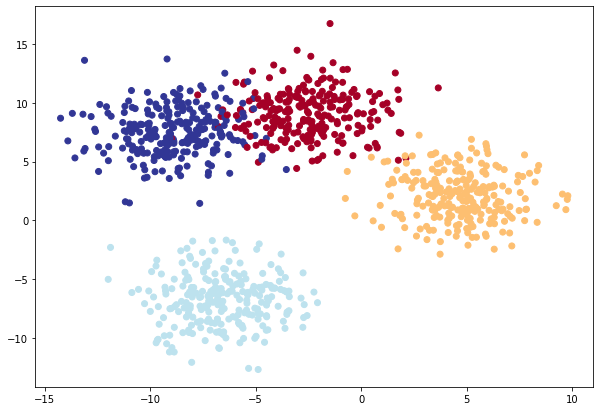

In [219]:
# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=2, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

## 2. Build Model

In [220]:
# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [221]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model(X_blob_train.to(device))[:5]

tensor([[-0.8076, -0.7052, -1.6032, -1.1852],
        [-0.2484, -1.2522, -1.0065, -0.2962],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [ 0.2296, -0.2598,  0.1238,  0.0327],
        [-0.0906, -0.9147, -0.6144, -0.1662]], device='cuda:0',
       grad_fn=<SliceBackward0>)

The raw output of the last layer of a neural network, before applying any activation function or probability distribution is called `logits`. In other words, `logits` are the unnormalized numerical values that represent the predictions of a model for each class. The values can be positive or negative, and their magnitudes reflect the strength of the model's confidence in the prediction. After obtaining logits, they can be transformed into prediction probabilities using a softmax function, and then converted to prediction labels by selecting the class with the highest probability.

So the flows from logits to final label is:  `logits -> prediction probabilities -> prediction labels`

In [222]:
# Make prediction logits with model
y_logits = model(X_blob_test.to(device))


# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.8118, -0.8307, -1.6751, -1.1760],
        [-0.0902, -0.9269, -0.5813, -0.1338],
        [ 0.2456, -0.2423,  0.1883, -0.0032],
        [-0.3472, -0.4911, -0.8196, -0.6231],
        [-0.3540, -1.4595, -1.3139, -0.4283]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.3228, 0.3168, 0.1361, 0.2243],
        [0.3331, 0.1443, 0.2038, 0.3188],
        [0.2996, 0.1839, 0.2829, 0.2336],
        [0.3078, 0.2666, 0.1919, 0.2336],
        [0.3785, 0.1253, 0.1449, 0.3514]], device='cuda:0',
       grad_fn=<SliceBackward0>)



These prediction probablities are essentially saying how much the model thinks the target `X` sample (the input) maps to each class.

Since there's one value for each class in `y_pred_probs`, the index of the highest value is the class the model thinks the specific data sample most belongs to.

We can check which index has the highest value using `torch.argmax()`.

In [223]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]).item())

tensor([0.3228, 0.3168, 0.1361, 0.2243], device='cuda:0',
       grad_fn=<SelectBackward0>)
0


In most cases, it is recommended to **provide logits as an input to the loss function instead of prediction probabilities**. This is because the logits are the outputs of the model before they are passed through the activation function (such as softmax) to obtain the prediction probabilities. The loss function, in turn, is designed to work with the logits to compute the gradients necessary for backpropagation during training.

Using the prediction probabilities directly as inputs to the loss function can lead to numerical instability and suboptimal training, especially when the probabilities are close to 0 or 1. Therefore, it is better to compute the logits, apply the activation function to obtain the probabilities, and then use the logits as inputs to the loss function.

Also, note that in pytorch, when computing loss functions associated to probabilities, normally the logits are used as input instead of the normalized probabilities i.e. [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

In [231]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss() #computes the cross entropy loss between input logits and target.
optimizer = torch.optim.SGD(model.parameters(),lr=0.1) 

## 3. Train and Test Loop

For the **`training loop`**, we'll build the following steps:

<table>
<thead>
  <tr>
    <th>Step Names</th>
    <th>What does it do?</th>
    <th>Code example</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td><b> Forward pass</b></td>
    <td>The model goes through all of the training data once, performing its forward() function calculations.</td>
    <td><code>model(x_train)</code></td>
  </tr>
  <tr>
    <td><b>Calculate the loss</b></td>
    <td>The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are.</td>
    <td><code>loss = loss_fn(y_pred, y_train)</code></td>
  </tr>
  <tr>
    <td><b>Zero gradients</b></td>
    <td>The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step.</td>
    <td><code>optimizer.zero_grad()</code></td>
  </tr>
  <tr>
    <td><b>Perform backpropagation on the loss</b></td>
    <td>Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with <code>requires_grad=True</code>). This is known as backpropagation, hence "backwards".</td>
    <td><code>loss.backward()</code></td>
  </tr>
  <tr>
    <td><b>Update the optimizer (gradient descent)</b></td>
    <td>Update the parameters with requires_grad=True with respect to the loss gradients in order to improve them.</td>
    <td><code>optimizer.step()</code></td>
  </tr>
</tbody>
</table>

<div align="center">
<img src="https://raw.githubusercontent.com/dev-SR/Deep-Learning/main/02-pytorch-workflow-classification/img/01-pytorch-training-loop-annotated.png" alt="train" width="900px">
</div>

And on the ordering of things, the above is a good default order but you may see slightly different orders. Some rules of thumb:

- Calculate the loss (`loss = ...`) before performing backpropagation on it (loss. backward()).
- Zero gradients (`optimizer.zero_grad()`) before stepping them (`optimizer.step()`).
- Step the optimizer (`optimizer.step()`) after performing backpropagation on the loss (`loss.backward()`).

As for the **`testing loop`** (evaluating our model), the typical steps include:

<table>
<thead>
  <tr>
    <th>Step Names</th>
    <th>What does it do?</th>
    <th>Code example</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td><b> Forward pass</b></td>
    <td>The model goes through all of the testing data once, performing its forward() function calculations.</td>
    <td><code>model(x_test)</code></td>
  </tr>
  <tr>
    <td><b>Calculate the loss</b></td>
    <td>The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are.</td>
    <td><code>loss = loss_fn(y_pred, y_test)</code></td>
  </tr>
  <tr>
    <td><b>Calulate evaluation metrics (optional)</b></td>
    <td>Alongisde the loss value you may want to calculate other evaluation metrics such as accuracy on the test set.</td>
    <td>Custom functions</td>
  </tr>
</tbody>
</table>

Notice the testing loop doesn't contain performing backpropagation (`loss.backward()`) or stepping the optimizer (`optimizer.step()`), this is because no parameters in the model are being changed during testing, they've already been calculated. For testing, we're only interested in the output of the forward pass through the model.

<div align="center">
<img src="https://raw.githubusercontent.com/dev-SR/Deep-Learning/main/02-pytorch-workflow-classification/img/01-pytorch-testing-loop-annotated.png" alt="train" width="900px">
</div>


In [232]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) 
    return acc

In [233]:
model = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [234]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss() #computes the cross entropy loss between input logits and target.
optimizer = torch.optim.SGD(model.parameters(),lr=0.1) 

In [235]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []
train_accuracy_values = []
test_accuracy_values = []

for epoch in range(epochs):
    ### Training
    model.train()

    # 1. Forward pass
    y_logits = model(X_blob_train) # model outputs raw logits 
    # go from logits -> prediction probabilities -> prediction labels
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) 
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)


    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()


    ### Testing
    # Put the model in evaluation mode
    model.eval()

    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)


    # Print out what's happening
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        train_loss_values.append(loss.cpu().detach().numpy())
        test_loss_values.append(test_loss.cpu().detach().numpy())
        train_accuracy_values.append(acc)
        test_accuracy_values.append(test_acc)
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f}, Train Acc: {acc:.2f} | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}") 

Epoch: 0 | Train Loss: 1.16741, Train Acc: 0.41 | Test Loss: 1.08563, Test Acc: 0.50
Epoch: 10 | Train Loss: 0.68131, Train Acc: 0.93 | Test Loss: 0.69426, Test Acc: 0.92
Epoch: 20 | Train Loss: 0.47821, Train Acc: 0.95 | Test Loss: 0.48371, Test Acc: 0.95
Epoch: 30 | Train Loss: 0.32163, Train Acc: 0.96 | Test Loss: 0.31335, Test Acc: 0.97
Epoch: 40 | Train Loss: 0.18300, Train Acc: 0.96 | Test Loss: 0.16929, Test Acc: 0.96
Epoch: 50 | Train Loss: 0.13164, Train Acc: 0.96 | Test Loss: 0.11941, Test Acc: 0.96
Epoch: 60 | Train Loss: 0.11502, Train Acc: 0.96 | Test Loss: 0.10250, Test Acc: 0.96
Epoch: 70 | Train Loss: 0.10735, Train Acc: 0.96 | Test Loss: 0.09457, Test Acc: 0.96
Epoch: 80 | Train Loss: 0.10301, Train Acc: 0.96 | Test Loss: 0.09010, Test Acc: 0.96
Epoch: 90 | Train Loss: 0.10023, Train Acc: 0.96 | Test Loss: 0.08731, Test Acc: 0.96


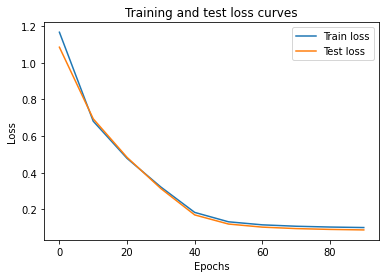

In [236]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

# plt.plot(train_loss_arr,label="train_loss_arr")
# plt.plot(train_accuracy_arr,label="train_accuracy_arr")
# plt.plot(test_loss_arr,label="test_loss_arr")
# plt.plot(test_accuracy_arr,label="test_accuracy_arr")
# plt.legend()

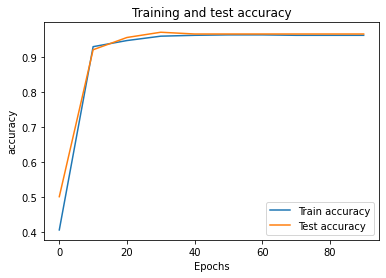

In [237]:
# Plot the loss curves
plt.plot(epoch_count, train_accuracy_values, label="Train accuracy")
plt.plot(epoch_count, test_accuracy_values, label="Test accuracy")
plt.title("Training and test accuracy")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.legend();

# plt.plot(train_loss_arr,label="train_loss_arr")
# plt.plot(train_accuracy_arr,label="train_accuracy_arr")
# plt.plot(test_loss_arr,label="test_loss_arr")
# plt.plot(test_accuracy_arr,label="test_accuracy_arr")
# plt.legend()

## 4. Making predictions with a trained PyTorch model (inference)

Once you've trained a model, you'll likely want to make predictions with it.

There are three things to remember when making predictions (also called performing inference) with a PyTorch model:

- Set the model in evaluation mode (`model.eval()`).
- Make the predictions using the inference mode context manager (`with torch.inference_mode(): ...`).
- All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only).

In [241]:
# 1. Set the model in evaluation mode
model.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
    y_logits = model(X_blob_test)

# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 0.965%


## 5. Saving and loading a PyTorch model¶


### Saving a PyTorch `model.state_dict()`

In [242]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models/01_pytorch_workflow_model_0.pth


### Loading a saved PyTorch model's state_dict()¶
 

In [244]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [246]:
loaded_model.eval()
with torch.inference_mode():
    y_logits = loaded_model(X_blob_test)

y_pred_probs = torch.softmax(y_logits, dim=1)
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 0.965%
